Model 2:

Target:

- Add Regularization (Dropout) & Batch-norm to increase model efficiency.
- Add GAP and remove the last BIG kernel to reduce size

Results:
- Parameters: 6.2K
- Best Train Accuracy: 98.75
- Best Test Accuracy: 96.58

Analysis:
- Model is lightweight now, with help of GAP
- No over-fitting, Gap between train and test accuracy is close
- Add more capacity to improve accuracy


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block 28  >>> 64
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26 >>> 62

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24. >>> 60
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22 >>> 58

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11 >>> 29

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9 >>> 27
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7 >>> 25

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7 >>> 25
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # Keeps output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 14
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.15014919638633728 Batch_id=468 Accuracy=92.89: 100%|██████████| 469/469 [00:07<00:00, 63.62it/s] 



Test set: Average loss: 0.2341, Accuracy: 9342/10000 (93.42%)

EPOCH: 1


Loss=0.18662802875041962 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:07<00:00, 62.38it/s]  



Test set: Average loss: 0.0864, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.09679324179887772 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:08<00:00, 57.17it/s]  



Test set: Average loss: 0.0839, Accuracy: 9744/10000 (97.44%)

EPOCH: 3


Loss=0.10518071800470352 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s]  



Test set: Average loss: 0.0691, Accuracy: 9789/10000 (97.89%)

EPOCH: 4


Loss=0.0798594281077385 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:07<00:00, 64.42it/s]   



Test set: Average loss: 0.0619, Accuracy: 9826/10000 (98.26%)

EPOCH: 5


Loss=0.05687643215060234 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:07<00:00, 64.43it/s]  



Test set: Average loss: 0.0621, Accuracy: 9807/10000 (98.07%)

EPOCH: 6


Loss=0.04749925062060356 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:07<00:00, 62.48it/s]  



Test set: Average loss: 0.0470, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.010906456969678402 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:07<00:00, 62.36it/s]  



Test set: Average loss: 0.0498, Accuracy: 9840/10000 (98.40%)

EPOCH: 8


Loss=0.057603444904088974 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:07<00:00, 62.70it/s] 



Test set: Average loss: 0.0499, Accuracy: 9837/10000 (98.37%)

EPOCH: 9


Loss=0.022477060556411743 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:07<00:00, 63.12it/s]  



Test set: Average loss: 0.0515, Accuracy: 9849/10000 (98.49%)

EPOCH: 10


Loss=0.012594752945005894 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:07<00:00, 64.02it/s]  



Test set: Average loss: 0.0394, Accuracy: 9870/10000 (98.70%)

EPOCH: 11


Loss=0.09113306552171707 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:07<00:00, 62.81it/s]   



Test set: Average loss: 0.0438, Accuracy: 9880/10000 (98.80%)

EPOCH: 12


Loss=0.025003252550959587 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:07<00:00, 63.50it/s] 



Test set: Average loss: 0.0477, Accuracy: 9835/10000 (98.35%)

EPOCH: 13


Loss=0.015581675805151463 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:07<00:00, 63.76it/s]  



Test set: Average loss: 0.0498, Accuracy: 9858/10000 (98.58%)



Text(0.5, 1.0, 'Test Accuracy')

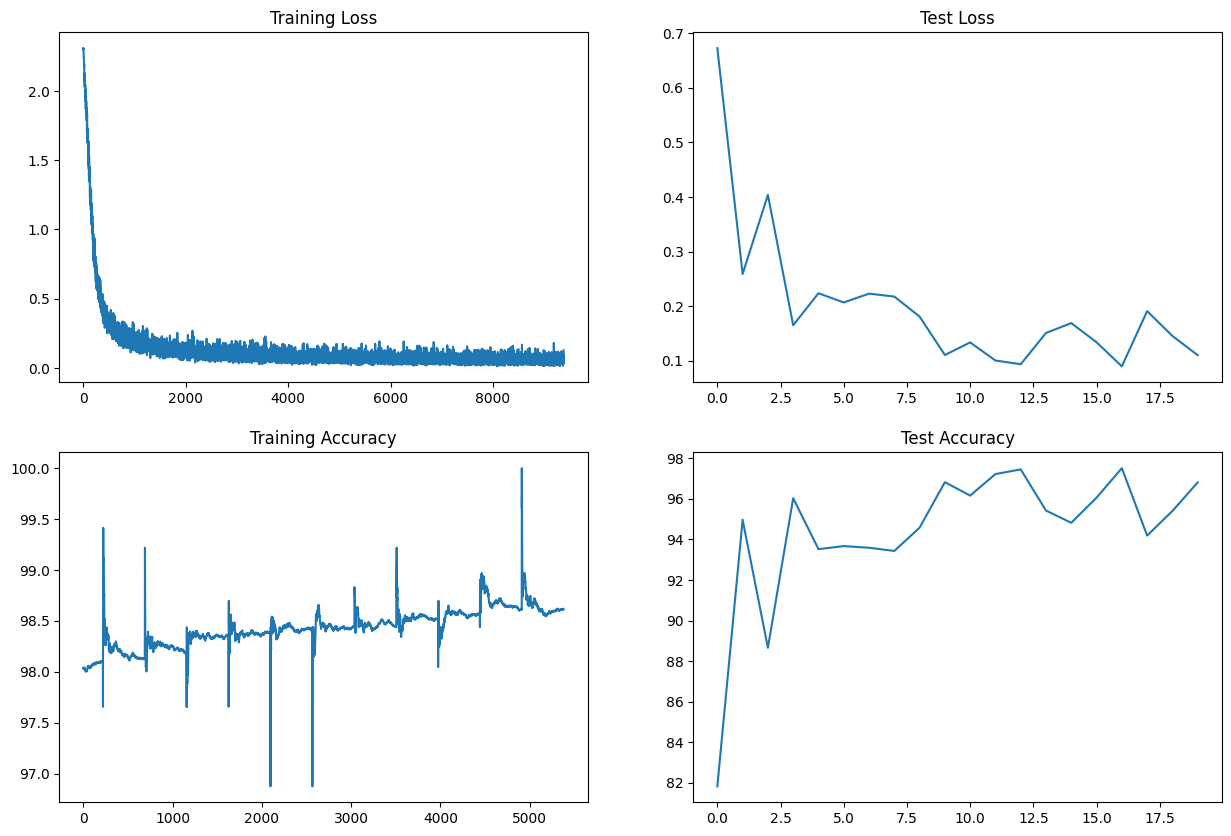

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")